## Time-Series Decomposition (More classical approaches)

Extract the seasonal patterns from the time-series

In [392]:
from data_exploitation.exports_analytics.data.scripts import time_series_generator
from data_exploitation.exports_analytics.exploratory_data_analysis.scripts import time_granularities_analysis, time_granularities_generator
from database_settings import postgres_utilities
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import linear_model

### Get available headings

In [393]:
# Get available headings from peru_exports_sandbox
engine = postgres_utilities.engine()
available_headings = postgres_utilities.run_query_file(engine,
                                                       './../data/queries/read_available_headings.sql')
available_headings = pd.DataFrame(available_headings)
available_headings

Connected to Formatted Zone successfully!


,heading,description
0,0712909000,Otras hortalizas y mezclas de hortalizas corta...
1,0805291000,Tangelo (Citrus reticulata x Citrus paradisis)...
2,0810400000,"Arándanos rojos, mirtilos y demas frutos del g..."
3,0713359000,"Frijoles (fréjoles, porotos, alubias, judías) ..."
4,0805502100,"Limón (limón sutil, limón común, limón criollo..."
5,0810901000,"Granadilla, maracuya (parchita) y demas frutas..."
6,0702000000,Tomates frescos o refrigerados
7,0709999000,Otras hortalizas frescas o refrigeradas
8,0801220000,Nueces del Brasil sin cáscara
9,0710400000,"Maiz dulce incluso cocidos, congelados"


### Build a time-series

In [394]:
# Choose a heading
chosen_heading = '0810400000'
# Choose the observed measure (usd_kg or net_weight)
observations = 'usd_kg'

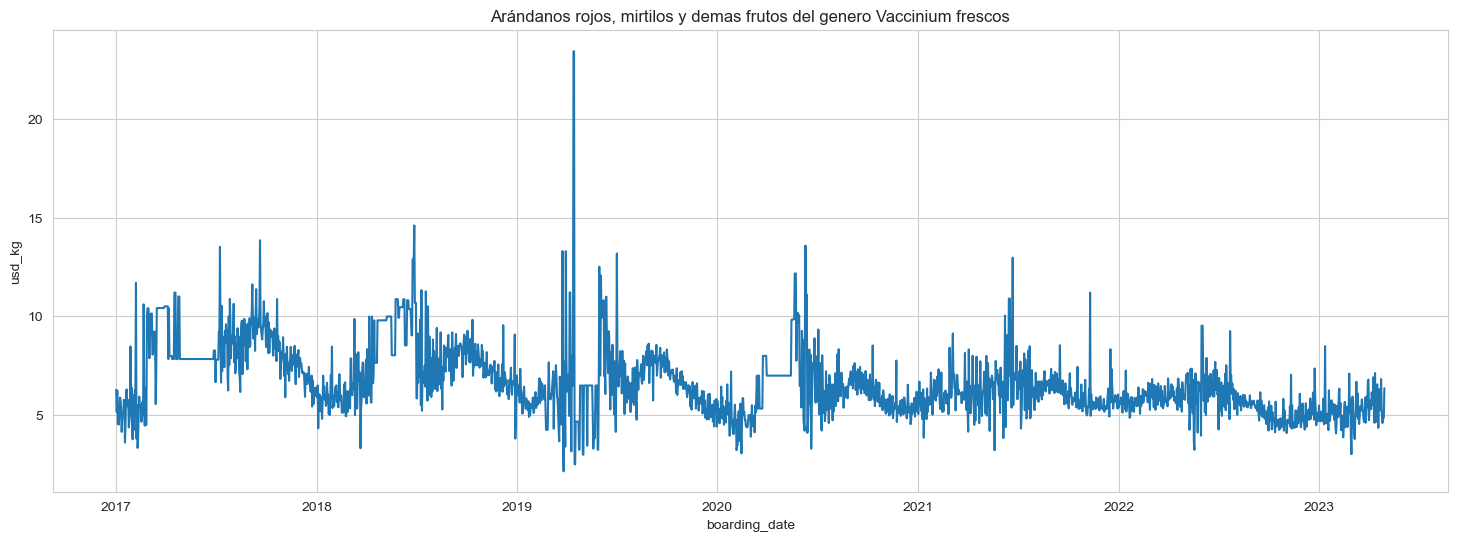

In [395]:
# Get a time-series
ts = time_series_generator.generate(chosen_heading, observations)
ts.plot()

In [396]:
# Add the time granularities
time_granularities, priority = time_granularities_generator.generate(ts.start_date, ts.end_date)
data = pd.concat([ts.data, time_granularities], axis=1)
data

,usd_kg,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-01,6.280,2017,1,1,1,1,1,1,1,1,1,1,7,52,26,13,5
2017-01-02,5.144,2017,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1
2017-01-03,6.243,2017,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1
2017-01-04,4.551,2017,1,1,1,1,1,1,4,4,4,4,3,1,1,1,1
2017-01-05,4.590,2017,1,1,1,1,1,1,5,5,5,5,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26,4.610,2023,1,2,4,4,1,2,116,116,26,26,3,17,17,4,4
2023-04-27,4.610,2023,1,2,4,4,1,2,117,117,27,27,4,17,17,4,4
2023-04-28,4.874,2023,1,2,4,4,1,2,118,118,28,28,5,17,17,4,4
2023-04-29,4.874,2023,1,2,4,4,1,2,119,119,29,29,6,17,17,4,4


### Get a list of the seasonal patterns to extract

In [397]:
# Get a list of seasonal patterns in order of extraction
def get_existing_granularities(granularities, data, observations):

    selected_granularities = []
    for g in granularities:
        # print('Analyzing {}...'.format(g))
        seasonality_analysis = time_granularities_analysis.analysis(cyclic_granularity=g,
                                        observations=observations,
                                        data=data)
        # seasonality_analysis.plot()
        # print(seasonality_analysis.summary())
        if seasonality_analysis.is_seasonal():
            selected_granularities.append(g)
            # seasonality_analysis.plot()
    selected_granularities = [x for x in priority if x in selected_granularities]
    selected_granularities

    return selected_granularities

In [398]:
# # Define the granularities to analyze
# granularities = ['semester_in_year',
#                  'quarter_in_year',
#                  'month_in_year',
#                  'month_in_semester',
#                  'month_in_quarter',
#                  'quarter_in_semester',
#                  'day_in_month',
#                  'day_in_week',
#                  'week_in_year',
#                  'week_in_semester',
#                  'week_in_quarter',
#                  'week_in_month']
# selected_granularities = get_existing_granularities(granularities, data, observations)

### Extraction approaches

In [404]:
# Approach 1: Get the seasonal patterns in an additive way, first removing the lower level time granularities

def approach_1(data, selected_granularities):

    # Initialize the residuals
    residuals = data['residuals'].values
    # Initialize the seasonal patterns
    seasonal_patterns = {}

    # Set the level of refinement
    for i in range(10):

        # Get the pattern for every granularity
        for granularity in selected_granularities:

            # Refine the pattern (if already extracted before)
            if granularity in seasonal_patterns:
                residuals = residuals + seasonal_patterns[granularity]

            # Get the label of every observation
            labels = data[granularity].values
            # Generate the pattern
            pattern = []
            for label in labels:
                value = np.mean(residuals[np.where(labels == label)])
                pattern.append(value)
            seasonal_patterns[granularity] = pattern

            # Remove the pattern from the time-series
            residuals = residuals-pattern

    return residuals, seasonal_patterns

In [401]:
#Approach 2: Get the seasonal patterns. Each pattern is extracted directly from the original series. Then a linear regression is applied to get the exact contribution of each pattern to the original series

def approach_2(data, selected_granularities):

    # Initialize the residuals
    residuals = data['residuals'].values

    # Initialize the seasonal patterns
    seasonal_patterns = {}

    # Get the pattern for every granularity
    for granularity in selected_granularities:

        # Get the label of every observation
        labels = data[granularity].values
        # Generate the pattern
        pattern = []
        for label in labels:
            filtered_indexes = np.where(labels == label)[0]
            value = np.mean(residuals[filtered_indexes])
            pattern.append(value)
        seasonal_patterns[granularity] = pattern

    # Convert dictionary to a 2D array
    X_array = np.column_stack([series for series in seasonal_patterns.values()])

    # Make the linear regression to get the contribution of each pattern to the time-series
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(X_array, residuals)
    coefficients = regr.coef_
    # print(coefficients)

    balanced_seasonal_patterns = {}
    # Multiply each coefficient with the corresponding pattern
    for index, (key, pattern) in enumerate(seasonal_patterns.items()):
        coef = coefficients[index]
        new_pattern = [value * coef for value in pattern]
        balanced_seasonal_patterns[key] = new_pattern

    # Get the residuals
    for key, pattern in balanced_seasonal_patterns.items():
        residuals = residuals - pattern

    return residuals, balanced_seasonal_patterns

### Extraction process

In [406]:
def get_seasonal_patterns(data, observations, method):

    # Initialize the residuals
    data['residuals'] = data[observations].values
    # data['residuals']  = np.insert(np.diff(data[observations].values),0,data[observations].values[0])

    # Initialize the seasonal patterns
    seasonal_patterns ={}
    # Define the granularities to analyze
    granularities = ['semester_in_year',
                     'quarter_in_year',
                     'month_in_year',
                     'month_in_semester',
                     'month_in_quarter',
                     'quarter_in_semester',
                     'day_in_month',
                     'day_in_week',
                     'week_in_year',
                     'week_in_semester',
                     'week_in_quarter',
                     'week_in_month']

    # Set the number of extractions
    for i in tqdm(range(1)):
        # Get the granularities to extract
        selected_granularities = get_existing_granularities(granularities, data, 'residuals')
        # selected_granularities = granularities
        # Update the residuals and get the new batch of seasonal patterns
        residuals, new_patterns = method(data, selected_granularities)
        # print(np.sum(np.abs(data['residuals'] - residuals)))
        data['residuals'] = residuals
        # Update the seasonal patterns
        for granularity, pattern in new_patterns.items():
            if granularity in seasonal_patterns:
                seasonal_patterns[granularity] = np.add(seasonal_patterns[granularity], pattern)
            else:
                seasonal_patterns[granularity] = pattern

    # # Get the final residuals
    # residuals = data['residuals']

    return residuals, seasonal_patterns

In [407]:
residuals, seasonal_patterns = get_seasonal_patterns(data,
                                                     observations,
                                                     approach_1)

  0%|          | 0/1 [00:00<?, ?it/s]

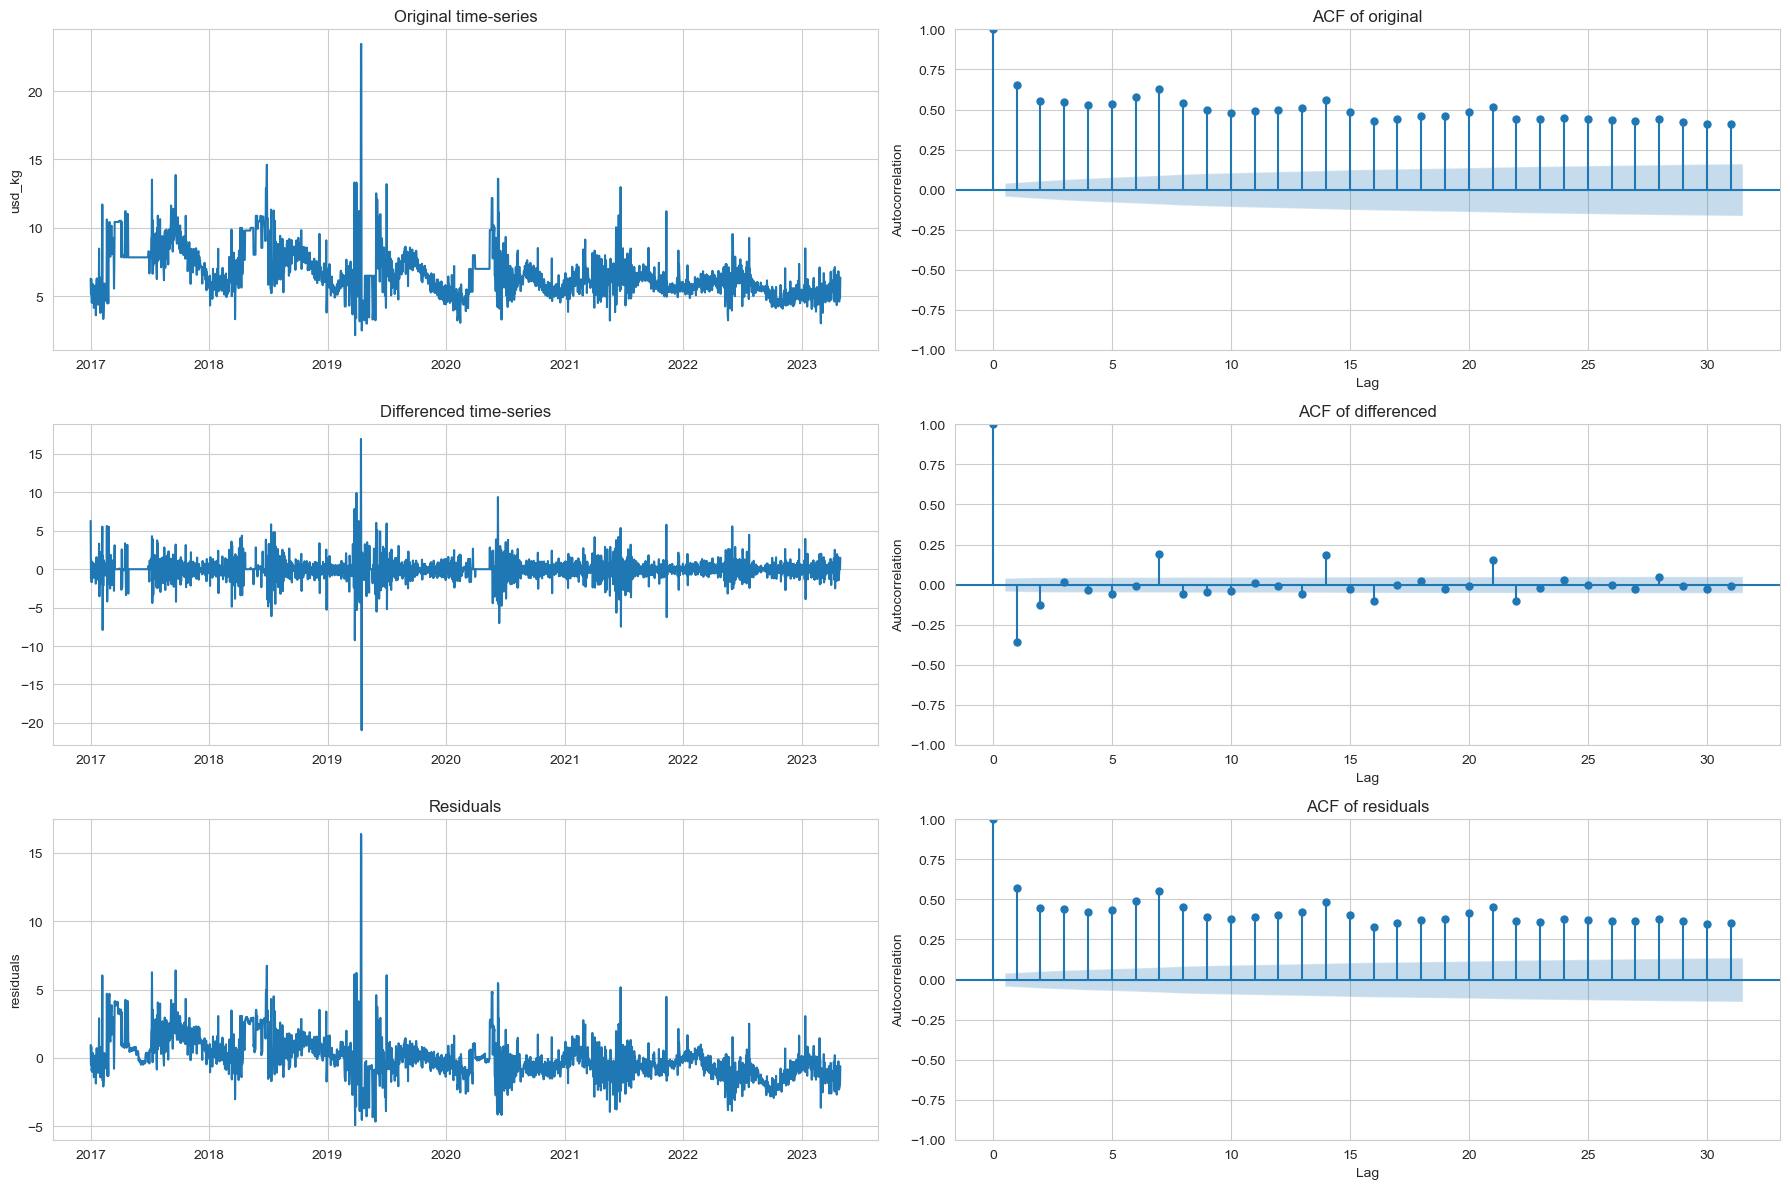

In [408]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Set the number of plots and columns for subplots
num_columns = 2
num_rows = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, 12))

# Flatten the axes array if there's only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Plot original
sns.lineplot(x=data.index, y=data[observations], ax=axes[0, 0])
axes[0, 0].set_title('Original time-series')

# Plot ACF of original
plot_acf(data[observations], lags=31, alpha=0.05, ax=axes[0, 1])
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('Autocorrelation')
axes[0, 1].set_title('ACF of original')

# Plot differenced
sns.lineplot(x=data.index, y=np.insert(np.diff(data[observations].values), 0, data[observations].values[0]), ax=axes[1, 0])
axes[1, 0].set_title('Differenced time-series')

# Plot ACF of differenced
plot_acf(np.insert(np.diff(data[observations].values), 0, data[observations].values[0]), lags=31, alpha=0.05, ax=axes[1, 1])
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].set_title('ACF of differenced')

# Plot residuals
sns.lineplot(x=data.index, y=data['residuals'], ax=axes[2, 0])
axes[2, 0].set_title('Residuals')

# Plot ACF of differenced + deseasonalized
plot_acf(data['residuals'], lags=31, alpha=0.05, ax=axes[2, 1])
axes[2, 1].set_xlabel('Lag')
axes[2, 1].set_ylabel('Autocorrelation')
axes[2, 1].set_title('ACF of residuals')

# Adjust spacing between subplots
fig.tight_layout()

# Show the plots
plt.show()

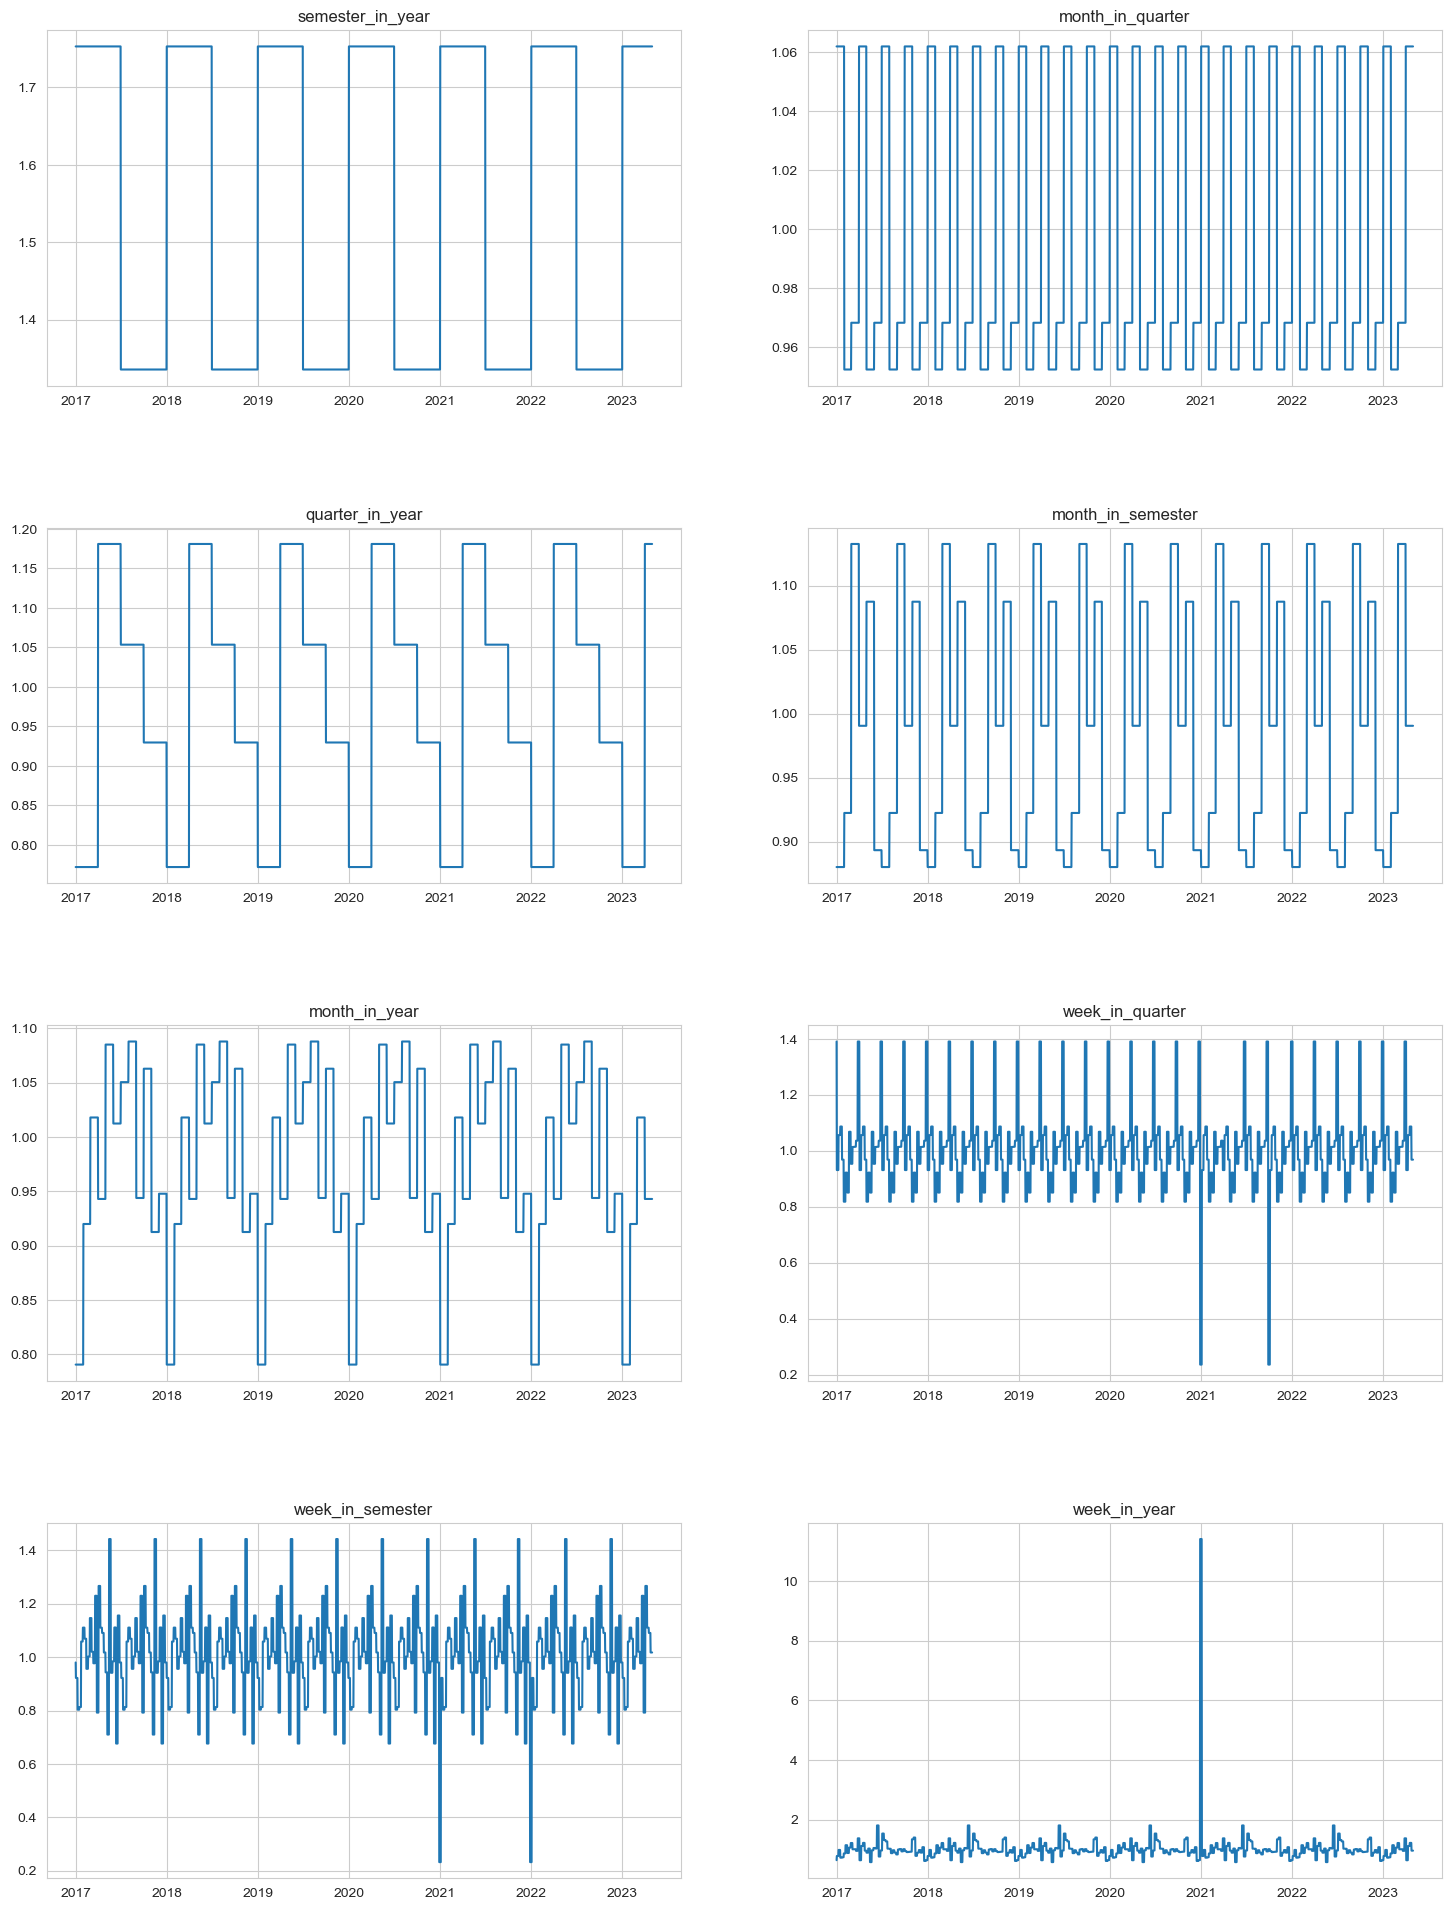

In [384]:
# Plot seasonal patterns

num_patterns = len(seasonal_patterns)
num_rows = (num_patterns + 1) // 2  # Calculate the number of rows needed for subplots

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(18, 6 * num_rows))
plt.subplots_adjust(hspace=0.4)  # Adjust the vertical spacing between subplots

# Iterate over seasonal patterns and plot them in the subplots
for i, (key, value) in enumerate(seasonal_patterns.items()):
    row = i // 2  # Row index of the subplot
    col = i % 2   # Column index of the subplot

    ax = axes[row, col]  # Get the current subplot
    sns.lineplot(x=data.index, y=value, ax=ax)
    ax.set_title(key)

# Remove empty subplots if there are more seasonal patterns than available subplots
if num_patterns % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show()


### Extract the trend

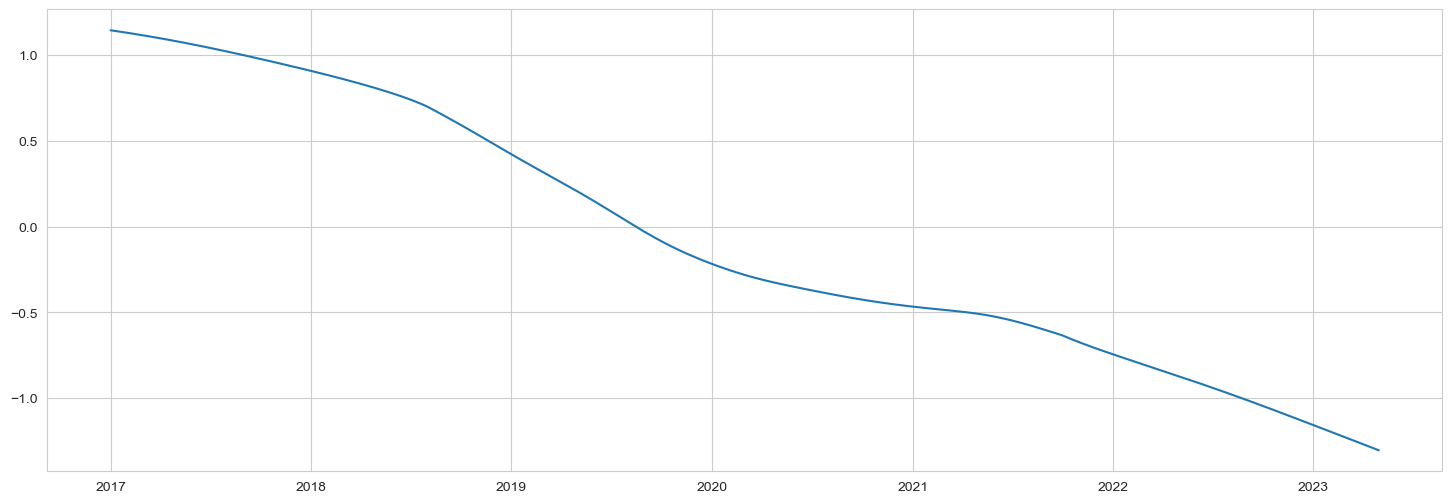

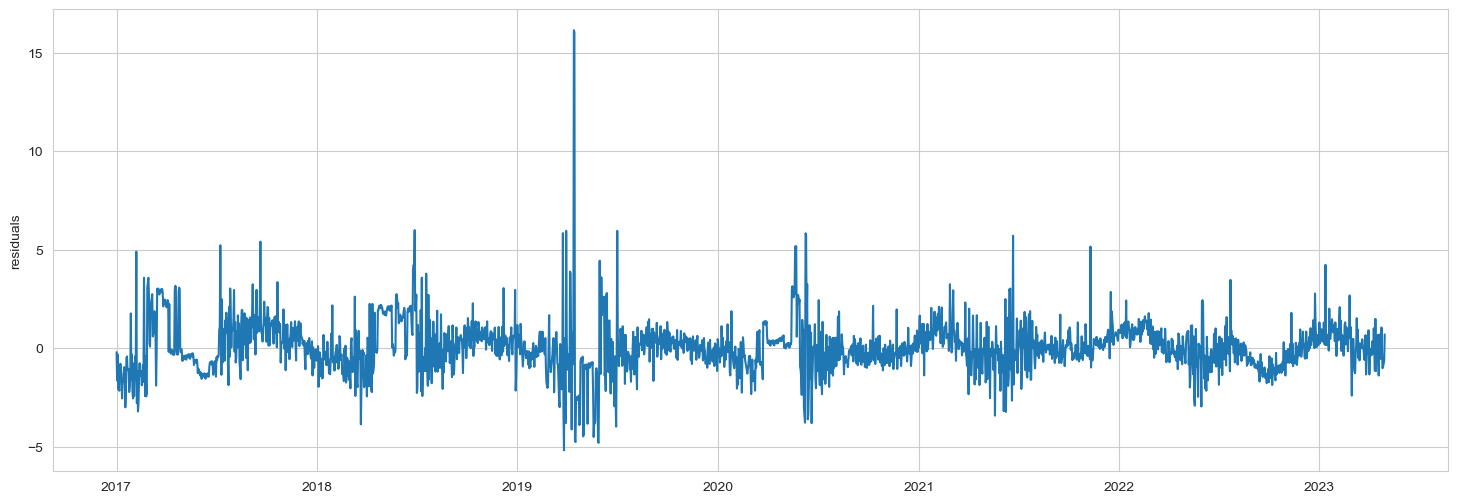

In [417]:
lowess = sm.nonparametric.lowess(data['residuals'], data.index, frac=0.5)

# Extract the trend component
trend = lowess[:, 1]

# Plot trend
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=trend)
plt.show()


# Plot residuals
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=data['residuals']-trend)
plt.show()

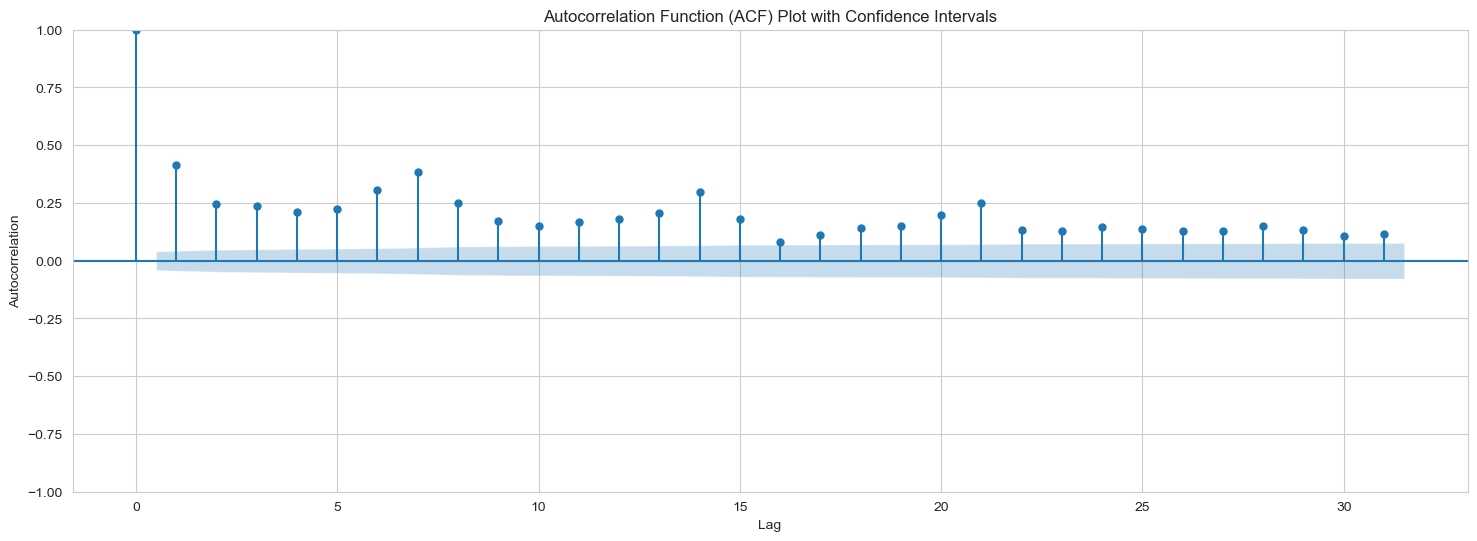

In [418]:
# Plot ACF with confidence intervals
fig, ax = plt.subplots(figsize=(18, 6))
plot_acf(data['residuals']-trend, lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
plt.xlabel('Lag')

plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot with Confidence Intervals')
plt.show()